# RAG Evaluation

For us to compare our different experiments, we need to evaluate them. We will be testing processes such as retrieval, generation with LLM-based metrics as well as classical non-LLM metrics such as BLEU, ROUGE and Cosine Similarity.

### RAGAS Metrics

We will be using the following LLM-based metrics from to evaluate the quality of the generated answers:

1. **Context Precision**: Context Precision is a metric that measures the proportion of relevant chunks in the retrieved_contexts. It is calculated as the mean of the precision@k for each chunk in the context. Precision@k is the ratio of the number of relevant chunks at rank k to the total number of chunks at rank k.

2. **Context Recall**: Context Recall measures how many of the relevant documents (or pieces of information) were successfully retrieved. It focuses on not missing important results. Higher recall means fewer relevant documents were left out. In short, recall is about not missing anything important. Since it is about not missing anything, calculating context recall always requires a reference to compare against.

3. **Faithfullness**: Faithfulness metric measures the factual consistency of the generated answer against the given context. It is calculated from answer and retrieved context. The answer is scaled to (0,1) range. Higher the better.

4. **Response Relevancy**: ResponseRelevancy metric focuses on assessing how pertinent the generated answer is to the given prompt. A lower score is assigned to answers that are incomplete or contain redundant information and higher scores indicate better relevancy. This metric is computed using the user_input, the retrived_contexts and the response.

For more information and metrics, check out the [documentation](https://docs.ragas.io/en/latest/concepts/metrics/available_metrics/)

### Non-LLM Metrics
1. **BLEU**: BLEU (Bilingual Evaluation Understudy) is a metric for evaluating a generated sentence to a reference sentence. It is based on the precision of n-grams (contiguous sequences of n items) in the generated sentence compared to the reference sentence. The BLEU score ranges from 0 to 1, where 1 means the generated sentence is identical to the reference sentence.

2. **ROUGE**: ROUGE (Recall-Oriented Understudy for Gisting Evaluation) is a metric for evaluating a generated sentence to a reference sentence. It is based on the recall of n-grams (contiguous sequences of n items) in the generated sentence compared to the reference sentence. The ROUGE score ranges from 0 to 1, where 1 means the generated sentence is identical to the reference sentence.

3. **Cosine Similarity**: Cosine similarity is a metric that measures how similar two vectors are. It is calculated by taking the dot product of the two vectors and dividing it by the product of the magnitudes of the two vectors. The cosine similarity score ranges from -1 to 1, where 1 means the two vectors are identical, 0 means the two vectors are orthogonal, and -1 means the two vectors are diametrically opposed.

## Imports

In [62]:
from dotenv import load_dotenv
import json
import os
import re

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import pandas as pd
import numpy as np
import time
import ast

from sklearn.metrics.pairwise import cosine_similarity

from ragas import EvaluationDataset, evaluate
from ragas.metrics import (
    context_precision,
    context_recall,
    faithfulness,
    answer_relevancy,
    
)

from openai import AzureOpenAI
import openai

import credentials

In [2]:
deployment_name = "gpt-4o"

client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),  
    api_version="2023-12-01-preview",
    azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
)

## Load Data

Here we load our csv and pickle files for evaluation.

In [3]:
def process_retrieved_contexts(row):
    if isinstance(row, str):  # If it's a string representation of a list
        parsed = ast.literal_eval(row)  # Parse the string into a list
        return parsed if isinstance(parsed, list) else [parsed]
    elif isinstance(row, list):  # If it's already a list
        return row
    else:  # If it's something else, convert to a single-item list
        return [row]

In [4]:
folder_path = "../data/experiments"
experiment_dataframes = {}

# Iterate over all files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        # Read the CSV file
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path)

        # Rename columns
        df = df.rename(columns={
            'question': 'user_input',
            'contexts': 'retrieved_contexts',
            'answer': 'response', 
            'ground_truth': 'reference'
        })

        # Ensure every row in `retrieved_contexts` is a list
        df['retrieved_contexts'] = df['retrieved_contexts'].apply(process_retrieved_contexts)

        experiment_dataframes[file_name] = df

print(f"Loaded datasets for {len(experiment_dataframes)} experiments.")
for experiment_name, dataset in experiment_dataframes.items():
    print(f"Experiment: {experiment_name}, Number of samples: {len(dataset)}")

Loaded datasets for 5 experiments.
Experiment: recursive_500_chunksize_50_overlap_text_embedding_3_large.csv, Number of samples: 23
Experiment: recursive_1000_chunksize_100_overlap_text_embedding_3_large.csv, Number of samples: 23
Experiment: recursive_500_chunksize_50_overlap_text_embedding_ada_002.csv, Number of samples: 23
Experiment: recursive_1000_chunksize_0_overlap_text_embedding_ada_002.csv, Number of samples: 23
Experiment: recursive_2500_chunksize_300_overlap_text_embedding_3_large.csv, Number of samples: 23


In [5]:
import pickle

# Path to the embeddings directory
embeddings_path = '../embeddings/'

# Read all pickle files in the embeddings directory
embedding_experiments = {}

for file_name in os.listdir(embeddings_path):
    if file_name.endswith('.pkl'):  # Filter for pickle files
        file_path = os.path.join(embeddings_path, file_name)
        experiment_name = os.path.splitext(file_name)[0]  # Remove .pkl for experiment name
        with open(file_path, 'rb') as f:
            chunked_data = pickle.load(f)  # Load the pickled DataFrame
            embedding_experiments[experiment_name] = chunked_data

# Debug: Check loaded experiments
print(f"Loaded {len(embedding_experiments)} embedding experiments.")
for exp_name, data in embedding_experiments.items():
    print(f"Experiment: {exp_name}, Total Chunks: {len(data)}")

Loaded 5 embedding experiments.
Experiment: recursive_2500_chunksize_300_overlap_text_embedding_3_large, Total Chunks: 21632
Experiment: recursive_500_chunksize_50_overlap_text_embedding_ada_002, Total Chunks: 92445
Experiment: recursive_1000_chunksize_0_overlap_text_embedding_ada_002, Total Chunks: 44795
Experiment: recursive_1000_chunksize_100_overlap_text_embedding_3_large, Total Chunks: 48039
Experiment: recursive_500_chunksize_50_overlap_text_embedding_3_large, Total Chunks: 108312


## Intrinsic Evaluation

Intrinsic evaluation assesses the quality of embeddings generated during chunking by calculating metrics like cosine similarity, precision@k and recall@k between query and chunk embeddings. This step evaluates how well the embeddings encode semantic meaning, independent of downstream tasks like retrieval or answer generation.

**Why Is It Necessary?**
- Quality Assurance: High-quality embeddings ensure semantically similar texts are closely aligned in vector space, improving retrieval and generation performance.
- Model Comparison: It helps identify the best combination of embedding models and chunking strategies.
- Pipeline Optimization: Results guide the selection of configurations for downstream tasks.


**What Are We Doing?**
- Simulating Queries: Randomly sample queries from chunked data and pair them with corresponding "ground truth chunks."
- Evaluating Metrics:
    - Cosine Similarity: Measures semantic alignment.
    - Precision@k: Proportion of relevant chunks in the top-k results.
    - Recall@k: Proportion of ground truth covered by top-k results.

In [6]:
def intrinsic_evaluation(embedding_data, query_embeddings, k=5):
    """
    Evaluate embedding quality intrinsically using cosine similarity, precision@k, and recall@k,
    handling overlaps in chunks.

    Args:
        embedding_data (DataFrame): DataFrame containing chunks and their embeddings.
        query_embeddings (DataFrame): DataFrame containing queries and their embeddings.
        k (int): Top-k for precision and recall.

    Returns:
        metrics (dict): Dictionary containing precision@k, recall@k, and mean cosine similarity.
    """
    # Filter out rows with NaN embeddings
    embedding_data = embedding_data.dropna(subset=['embeddings'])
    query_embeddings = query_embeddings.dropna(subset=['embeddings'])

    if embedding_data.empty or query_embeddings.empty:
        raise ValueError("Embedding data or query embeddings are empty after filtering NaN values.")

    precision_scores = []
    recall_scores = []
    cosine_similarities = []

    for _, query_row in query_embeddings.iterrows():
        query_embedding = query_row['embeddings']
        ground_truth_chunk = query_row['content_chunks']  # Use content_chunks from queries as ground truth

        # Calculate cosine similarities with all chunk embeddings
        embedding_data_copy = embedding_data.copy()  # Create a copy to avoid SettingWithCopyWarning
        embedding_data_copy['similarity'] = embedding_data_copy['embeddings'].apply(
            lambda emb: cosine_similarity(
                np.array(query_embedding).reshape(1, -1),
                np.array(emb).reshape(1, -1)
            ).flatten()[0]
        )

        # Get top-k most similar chunks
        top_k_chunks = embedding_data_copy.nlargest(k, 'similarity')

        # Unique Ground Truth Check for Overlapping Chunks
        relevant_chunks = top_k_chunks['content_chunks'].apply(
            lambda chunk: ground_truth_chunk in chunk
        )
        precision = relevant_chunks.sum() / k

        # Recall: Only check if the ground truth is found (once) in the top-k results
        recall = 1.0 if relevant_chunks.any() else 0.0

        # Store metrics
        precision_scores.append(precision)
        recall_scores.append(recall)
        cosine_similarities.append(embedding_data_copy['similarity'].mean())

    return {
        'precision@k': np.mean(precision_scores),
        'recall@k': np.mean(recall_scores),
        'mean_cosine_similarity': np.mean(cosine_similarities)
    }

def simulate_queries(chunked_data, num_queries=100):
    """
    Simulate a query dataset from the chunked data for intrinsic evaluation.

    Args:
        chunked_data (DataFrame): DataFrame containing all chunk embeddings.
        num_queries (int): Number of queries to simulate.

    Returns:
        query_embeddings (DataFrame): Sampled queries from the chunked data.
    """
    if len(chunked_data) < num_queries:
        raise ValueError(f"Not enough data to sample {num_queries} queries. Available: {len(chunked_data)}")
    return chunked_data.sample(n=num_queries, random_state=42)

In [7]:
# Intrinsic Evaluation for Each Experiment
embedding_metrics = {}

for experiment_name, chunked_data in tqdm(embedding_experiments.items(), desc="Evaluating Experiments"):
    print(f"\nIntrinsic Evaluation for Experiment: {experiment_name}")

    # Simulate queries for this experiment
    try:
        query_embeddings = simulate_queries(chunked_data, num_queries=100)
    except ValueError as e:
        print(f"Error in {experiment_name}: {e}")
        continue

    # Calculate intrinsic metrics
    try:
        metrics = intrinsic_evaluation(
            embedding_data=chunked_data,
            query_embeddings=query_embeddings,
            k=5
        )
        embedding_metrics[experiment_name] = metrics
        print(f"Completed {experiment_name}: {metrics}")
    except ValueError as e:
        print(f"Error in experiment {experiment_name}: {e}")

# Save Results for Analysis
embedding_metrics_df = pd.DataFrame.from_dict(embedding_metrics, orient='index')
embedding_metrics_df.reset_index(inplace=True)
embedding_metrics_df.rename(columns={"index": "Experiment"}, inplace=True)

print("\n=== Intrinsic Evaluation Results ===\n")
print(embedding_metrics_df)

Evaluating Experiments:   0%|          | 0/5 [00:00<?, ?it/s]


Intrinsic Evaluation for Experiment: recursive_2500_chunksize_300_overlap_text_embedding_3_large


Evaluating Experiments:  20%|██        | 1/5 [08:28<33:52, 508.25s/it]

Completed recursive_2500_chunksize_300_overlap_text_embedding_3_large: {'precision@k': 0.22, 'recall@k': 1.0, 'mean_cosine_similarity': 0.2992101446926566}

Intrinsic Evaluation for Experiment: recursive_500_chunksize_50_overlap_text_embedding_ada_002


Evaluating Experiments:  40%|████      | 2/5 [34:26<56:17, 1125.89s/it]

Completed recursive_500_chunksize_50_overlap_text_embedding_ada_002: {'precision@k': 0.21599999999999997, 'recall@k': 1.0, 'mean_cosine_similarity': 0.7528014627584233}

Intrinsic Evaluation for Experiment: recursive_1000_chunksize_0_overlap_text_embedding_ada_002


Evaluating Experiments:  60%|██████    | 3/5 [46:36<31:29, 944.92s/it] 

Completed recursive_1000_chunksize_0_overlap_text_embedding_ada_002: {'precision@k': 0.22424242424242424, 'recall@k': 1.0, 'mean_cosine_similarity': 0.7584985112600391}

Intrinsic Evaluation for Experiment: recursive_1000_chunksize_100_overlap_text_embedding_3_large


Evaluating Experiments:  80%|████████  | 4/5 [1:06:05<17:13, 1033.41s/it]

Completed recursive_1000_chunksize_100_overlap_text_embedding_3_large: {'precision@k': 0.22599999999999995, 'recall@k': 1.0, 'mean_cosine_similarity': 0.26079817650067083}

Intrinsic Evaluation for Experiment: recursive_500_chunksize_50_overlap_text_embedding_3_large


Evaluating Experiments: 100%|██████████| 5/5 [1:56:22<00:00, 1396.57s/it]

Completed recursive_500_chunksize_50_overlap_text_embedding_3_large: {'precision@k': 0.272, 'recall@k': 1.0, 'mean_cosine_similarity': 0.24806121878465798}

=== Intrinsic Evaluation Results ===

                                          Experiment  precision@k  recall@k  \
0  recursive_2500_chunksize_300_overlap_text_embe...     0.220000       1.0   
1  recursive_500_chunksize_50_overlap_text_embedd...     0.216000       1.0   
2  recursive_1000_chunksize_0_overlap_text_embedd...     0.224242       1.0   
3  recursive_1000_chunksize_100_overlap_text_embe...     0.226000       1.0   
4  recursive_500_chunksize_50_overlap_text_embedd...     0.272000       1.0   

   mean_cosine_similarity  
0                0.299210  
1                0.752801  
2                0.758499  
3                0.260798  
4                0.248061  


A recall of 1.0 indicates that the ground truth chunk was successfully retrieved within the top-k retrieved chunks for all evaluated queries

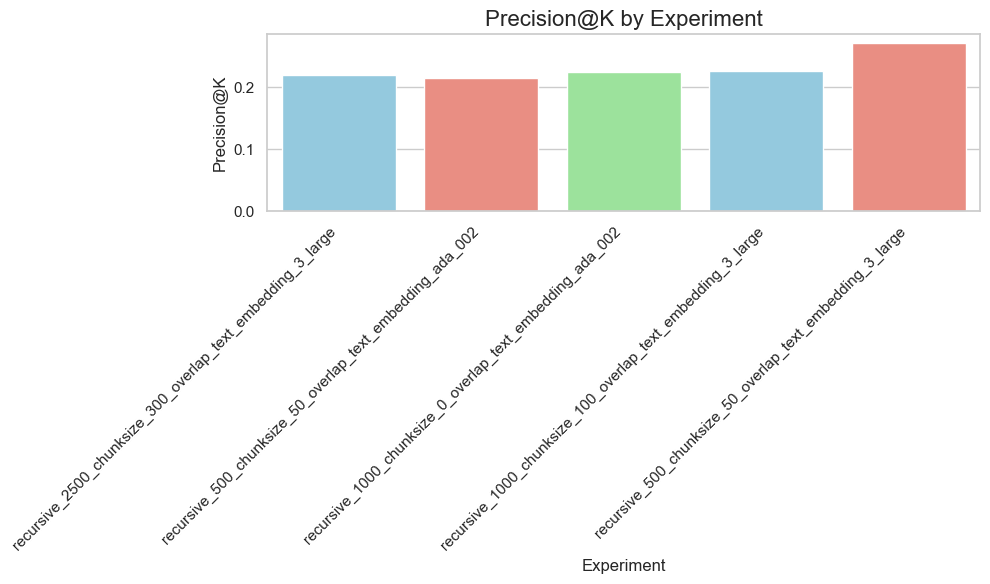

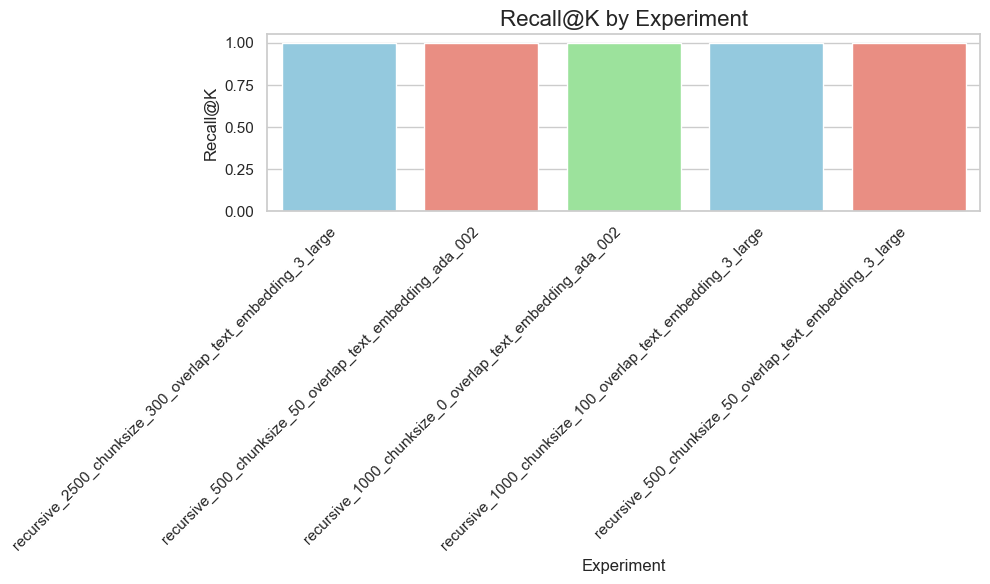

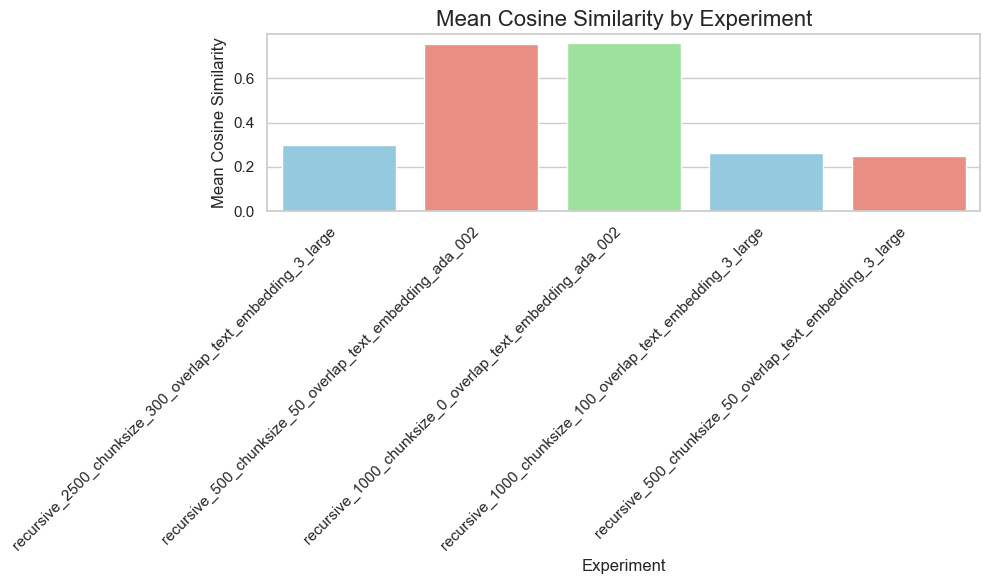

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style for seaborn
sns.set(style="whitegrid")

# Plot Precision@K, Recall@K, and Mean Cosine Similarity
metrics_to_plot = ['precision@k', 'recall@k', 'mean_cosine_similarity']

# Iterate over metrics and plot each
for metric in metrics_to_plot:
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=embedding_metrics_df,
        x='Experiment',
        y=metric,
        palette=['skyblue', 'salmon', 'lightgreen']
    )
    plt.title(f'{metric.replace("_", " ").title()} by Experiment', fontsize=16)
    plt.xlabel('Experiment', fontsize=12)
    plt.ylabel(metric.replace("_", " ").title(), fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

**Interpretation**

1. **Precision@K**:
   - The `precision@k` values across experiments are relatively low, with the highest being `0.272`. This suggests that while the models retrieve relevant chunks, only a fraction of the top 5 chunks (k=5) is relevant to the queries.
   - The embedding model `recursive_500_chunksize_50_overlap_text_embedding_3_large` performed best in terms of precision, indicating that smaller chunks with overlap and this embedding strategy might improve retrieval precision.

2. **Recall@K**:
   - All experiments show a `recall@k` of `1.0`. This indicates that the relevant chunks were successfully retrieved within the top 5 results for all queries, but overlapping chunks likely inflated this metric. Since chunk overlaps are present, the system retrieves multiple variants of the same relevant information, leading to perfect recall.
   
3. **Mean Cosine Similarity**:
   - The mean cosine similarity varies significantly, with values ranging from `0.248` to `0.758`. Models using `text-embedding-ada-002` achieve higher similarity scores, indicating that embeddings generated by this model are closer in vector space for relevant pairs.
   - In contrast, embeddings generated by `text-embedding-3-large` demonstrate lower cosine similarity, potentially reflecting differences in embedding dimensionality or quality for this specific dataset.

4. **Insights**:
   - While recall is perfect due to chunk overlaps, it masks underlying retrieval challenges, as reflected by the low precision and varying cosine similarity scores.
   - The results highlight a tradeoff between chunking strategies and embedding models. For example, smaller chunks with overlaps may improve precision but might not always result in higher cosine similarity.

## Retrieval Evaluation

**Purpose:**

This section evaluates the retriever's performance in selecting relevant contexts from the preprocessed dataset. Unlike intrinsic evaluation, which focuses on the quality of embeddings in isolation, retrieval evaluation measures how effectively the retriever utilizes embeddings to identify relevant chunks. This is a form of extrinsic evaluation, as it directly assesses the retriever's role in the RAG pipeline.

**Metrics:**

**Precision@K**
- Measures the proportion of relevant items among the top K retrieved items.
- This metric emphasizes the quality of the top-ranked contexts and how well the retriever prioritizes relevance.

**Recall@K**
- Measures the proportion of relevant items retrieved out of the total number of relevant items, limited to the top K retrieved contexts.
- This metric highlights the retriever's ability to comprehensively cover all relevant contexts, even within a constrained number of top results.

By analyzing these metrics, we gain insights into the retriever's effectiveness in narrowing down a large corpus into a smaller, highly relevant set of contexts for downstream tasks such as answer generation.

In [23]:
def precision_at_k(retrieved_contexts, ground_truth, k):
    retrieved_top_k = retrieved_contexts[:k]  # Only consider top K contexts
    # Handle multiple ground truths (if applicable)
    if isinstance(ground_truth, list):
        relevant = sum(1 for gt in ground_truth for context in retrieved_top_k if gt in context)
        return relevant / len(retrieved_top_k) if retrieved_top_k else 0.0
    else:
        relevant = sum(1 for context in retrieved_top_k if ground_truth in context)
        return relevant / len(retrieved_top_k) if retrieved_top_k else 0.0

def recall_at_k(retrieved_contexts, ground_truth, k):
    retrieved_top_k = retrieved_contexts[:k]
    # Handle multiple ground truths (if applicable)
    if isinstance(ground_truth, list):
        relevant = sum(1 for gt in ground_truth for context in retrieved_top_k if gt in context)
        return relevant / len(ground_truth)
    else:
        relevant = sum(1 for context in retrieved_top_k if ground_truth in context)
        return relevant / 1.0  # Single ground truth case
    
def evaluate_retrieval_metrics(dataset, k=3):
    """
    Evaluate retrieval metrics for a given dataset and top-k.

    Args:
        dataset (DataFrame): The dataset containing `retrieved_contexts` and `ground_truth`.
        k (int): The value of K for precision@k and recall@k.

    Returns:
        DataFrame: The dataset with added metric columns for the given k.
    """
    precision_at_ks, recalls_at_k = [], []
    for _, row in dataset.iterrows():
        precision_at_ks.append(precision_at_k(row['retrieved_contexts'], row['reference'], k))
        recalls_at_k.append(recall_at_k(row['retrieved_contexts'], row['reference'], k))

    # Add metrics to the dataset
    dataset[f'precision_at_{k}'] = precision_at_ks
    dataset[f'recall_at_{k}'] = recalls_at_k
    return dataset

In [29]:
evaluation_results = {}
k_values = [3, 5, 10] # List of k values to evaluate

for experiment_name, dataset in experiment_dataframes.items():
    experiment_name = experiment_name[:-4]
    print(f"Evaluating experiment: {experiment_name}")
    
    for k in k_values:
        dataset = evaluate_retrieval_metrics(dataset.copy(), k=k)
        evaluation_results[f'{experiment_name}_k={k}'] = dataset

        print(f"Results for K={k}:")
        print(f"Average Precision@{k}: {dataset[f'precision_at_{k}'].mean():.2f}")
        print(f"Average Recall@{k}: {dataset[f'recall_at_{k}'].mean():.2f}")
        print("--" * 20)

Evaluating experiment: recursive_500_chunksize_50_overlap_text_embedding_3_large
Results for K=3:
Average Precision@3: 0.09
Average Recall@3: 0.26
----------------------------------------
Results for K=5:
Average Precision@5: 0.07
Average Recall@5: 0.35
----------------------------------------
Results for K=10:
Average Precision@10: 0.07
Average Recall@10: 0.35
----------------------------------------
Evaluating experiment: recursive_1000_chunksize_100_overlap_text_embedding_3_large
Results for K=3:
Average Precision@3: 0.09
Average Recall@3: 0.26
----------------------------------------
Results for K=5:
Average Precision@5: 0.06
Average Recall@5: 0.30
----------------------------------------
Results for K=10:
Average Precision@10: 0.06
Average Recall@10: 0.30
----------------------------------------
Evaluating experiment: recursive_500_chunksize_50_overlap_text_embedding_ada_002
Results for K=3:
Average Precision@3: 0.07
Average Recall@3: 0.22
----------------------------------------


The retrieval evaluation shows that overlapping chunking strategies always outperform non-overlapping ones in both **Precision@K** and **Recall@K**, particularly at smaller K values. Smaller chunk sizes with overlaps provide richer context, leading to better relevance and coverage. 

**Precision** decreases slightly as K increases, while **Recall** improves as more relevant contexts are included. Strategies using `text_embedding_3_large` generally perform better than those using `text_embedding_ada_002` but the difference is not that significant. Non-overlapping strategies, like `recursive_1000_chunksize_0_overlap`, perform the worst, highlighting the importance of overlaps.

**Conclusion:**

Overlapping chunking strategies paired with `text_embedding_3_large` offer the best balance of precision and recall, making them more effective for retrieval tasks.

## LLM-Based Evaluation

**Purpose:**

This section evaluates the performance of the RAG system using an LLM to score the quality of generated answers. By leveraging the LLM's ability to assess relevance, accuracy and faithfulness, we can gain nuanced insights into the system's effectiveness beyond numerical metrics like precision and recall.

**LLM as an Evaluator:** The LLM is tasked with assessing the RAG pipeline output based on predefined criteria, such as:
- Relevance: Does the generated answer directly address the user's question and reference the retrieved contexts?
- Accuracy: Does the generated answer align with the ground truth reference?
- Faithfulness: Is the generated answer grounded in the retrieved contexts without introducing hallucinations?



In [33]:
evaluation_prompts = [
    """
    You are an evaluator for a Retrieval-Augmented Generation (RAG) system. Assess the quality of the following output:

    Question: {user_input}
    Reference Answer: {reference}
    Generated Answer: {response}
    Retrieved Contexts: {retrieved_contexts}

    Evaluation Criteria:
    1. **Relevance**: Does the generated answer address the question correctly and refer to the retrieved contexts? Rate on a scale of 1-10.
    2. **Accuracy**: Does the generated answer align with the reference answer? Rate on a scale of 1-10.
    3. **Faithfulness**: Is the generated answer faithful to the retrieved contexts? Rate on a scale of 1-10.
    4. **Overall Comments**: Provide any additional comments about the answer quality.

    Provide your evaluation in the following JSON format:
    {{
        "Relevance": X,
        "Accuracy": X,
        "Faithfulness": X,
        "OverallComments": "Your comments here."
    }}
    """,
    
    """
    You are acting as an experienced reviewer for an AI-powered Retrieval-Augmented Generation system. Your task is to critically evaluate the system's response to the question below, considering the provided reference answer and retrieved contexts.

    ### Context for Review:
    - **Question**: {user_input}
    - **Reference Answer**: {reference}
    - **Generated Answer**: {response}
    - **Retrieved Contexts**: {retrieved_contexts}

    ### Review Instructions:
    1. Analyze the **relevance** of the generated answer to the given question, especially considering the retrieved contexts.
    2. Assess the **accuracy** of the generated answer in comparison to the reference answer. Identify any inconsistencies or missing details.
    3. Evaluate the **faithfulness** of the generated answer to the retrieved contexts, ensuring it does not introduce unsupported claims or hallucinate information.

    ### Review Format:
    Provide a detailed evaluation in plain English, addressing the following questions:
    - **Relevance**: On a scale of 1-10, how closely does the answer align with the question and retrieved contexts? Explain your reasoning.
    - **Accuracy**: On a scale of 1-10, how accurately does the answer match the reference answer? Highlight any discrepancies or alignments.
    - **Faithfulness**: On a scale of 1-10, how faithful is the answer to the retrieved contexts? Note any unsupported claims or deviations.

    ### Your Evaluation:
    Return your review as a JSON object in this format:
    {{
        "Relevance": X,
        "Accuracy": X,
        "Faithfulness": X,
        "OverallComments": "Detailed comments highlighting the strengths and weaknesses of the generated answer."
    }}
"""
]

In [34]:
def evaluate_with_llm(client, deployment_name, user_input, reference, response, retrieved_contexts, prompt):
    """
    Evaluate the generated response using the specified LLM and prompt.
    """
    formatted_prompt = prompt.format(
        user_input=user_input,
        reference=reference,
        response=response,
        retrieved_contexts=retrieved_contexts
    )
    try:
        response = client.chat.completions.create(
            model=deployment_name,
            messages=[{"role": "user", "content": formatted_prompt}],
            max_tokens=250,
            temperature=0.0
        )
        answer = response.choices[0].message.content.strip()
        return answer
    except Exception as e:
        return {"error": str(e)}
    
def evaluate_dataset_with_prompts(client, deployment_name, eval_dataset, prompts):
    """
    Evaluate the dataset with multiple prompts.
    """
    results = {}
    for prompt_index, prompt in enumerate(prompts):
        prompt_results = []
        print(f"\nEvaluating with Prompt {prompt_index + 1}/{len(prompts)}")
        for _, row in tqdm(eval_dataset.iterrows(), total=len(eval_dataset), desc=f"Evaluating with Prompt {prompt_index + 1}"):
            user_input = row['user_input']
            reference = row['reference']
            response = row['response']
            retrieved_contexts = row['retrieved_contexts']
            
            evaluation = evaluate_with_llm(
                client, deployment_name, user_input, reference, response, retrieved_contexts, prompt
            )
            prompt_results.append({
                "user_input": user_input,
                "reference": reference,
                "response": response,
                "retrieved_contexts": retrieved_contexts,
                "evaluation": evaluation,
                "bleu_1": row['bleu_1'],
                "bleu_2": row['bleu_2'],
                "bleu_3": row['bleu_3'],
                "bleu_4": row['bleu_4'],
                "rouge_1": row['rouge1'],
                "rouge_2": row['rouge2'],
                "rouge_l": row['rougeL'],
                "cosine_similarity": row['cosine_similarity'],
                "prompt_index": prompt_index
            })
        results[f"Prompt_{prompt_index + 1}"] = prompt_results
    return results

In [ ]:
# Evaluate all experiment datasets with multiple prompts
all_prompt_results = {}
for experiment_name, eval_dataset in experiment_dataframes.items():
    print(f"\nEvaluating experiment: {experiment_name}")
    prompt_results = evaluate_dataset_with_prompts(client, deployment_name, eval_dataset, evaluation_prompts)
    all_prompt_results[experiment_name] = prompt_results
    print(f"Completed evaluation for {experiment_name}")

In [40]:
for experiment_name, results_by_prompt in all_prompt_results.items():
    for prompt_key, results in results_by_prompt.items():
        with open(f"evaluation_{experiment_name}_{prompt_key}.json", "w") as f:
            json.dump(results, f, indent=4)

### Parse and Prepare the Evaluation Data

In [64]:
directory_path = "../data/evaluation_llm_prompts/"

# Function to clean and parse the evaluation JSON string
def clean_and_parse_evaluation(json_string):
    """
    Cleans and parses the evaluation JSON string.
    Removes unnecessary formatting like triple backticks and ensures valid JSON structure.
    """
    try:
        # Remove triple backticks or markdown formatting
        cleaned_string = re.sub(r'```json\n|```', '', json_string).strip()
        # Extract only the JSON object if the string contains extra text
        json_match = re.search(r'\{.*\}', cleaned_string)
        if json_match:
            cleaned_string = json_match.group(0)
        # Parse the cleaned string into a JSON object
        return json.loads(cleaned_string)
    except json.JSONDecodeError as e:
        return None  # Return None if parsing fails (evaluation missing)

# Initialize a list for structured data
structured_data = []

# Process each JSON file in the directory
for file_name in tqdm(os.listdir(directory_path), desc="Processing JSON files"):
    if file_name.endswith('.json'):  # Only process JSON files
        file_path = os.path.join(directory_path, file_name)
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
            
            # Process each entry in the JSON file
            for entry in data:
                # Clean and parse the evaluation JSON field
                evaluation = clean_and_parse_evaluation(entry.get("evaluation", ""))
                if evaluation is None:
                    print(f"Failed to parse evaluation for entry: {entry.get('user_input')}")
                
                # Append the structured data
                structured_data.append({
                    "file_name": file_name,  # Keep track of the source file
                    "user_input": entry.get("user_input"),
                    "reference": entry.get("reference"),
                    "response": entry.get("response"),
                    "retrieved_contexts": entry.get("retrieved_contexts"),
                    "relevance": evaluation.get("Relevance", None) if evaluation else None,
                    "accuracy": evaluation.get("Accuracy", None) if evaluation else None,
                    "faithfulness": evaluation.get("Faithfulness", None) if evaluation else None,
                    "overall_comments": evaluation.get("OverallComments", None) if evaluation else None,
                    "bleu_1": entry.get("bleu_1"),
                    "bleu_2": entry.get("bleu_2"),
                    "bleu_3": entry.get("bleu_3"),
                    "bleu_4": entry.get("bleu_4"),
                    "rouge_1": entry.get("rouge_1"),
                    "rouge_2": entry.get("rouge_2"),
                    "rouge_l": entry.get("rouge_l"),
                    "cosine_similarity": entry.get("cosine_similarity"),
                    "prompt_index": entry.get("prompt_index"),
                })

# Convert to DataFrame
evaluation_df = pd.DataFrame(structured_data)

# Check for rows with missing values in parsed columns
missing_rows = evaluation_df[evaluation_df[['relevance', 'accuracy', 'faithfulness']].isnull().any(axis=1)]
if not missing_rows.empty:
    print("\n=== Rows with Missing Evaluation Metrics ===")
    print(missing_rows)

# Save the DataFrame as a CSV for further analysis
csv_output_path = "../data/evaluation_llm_prompts_parsed.csv"
evaluation_df.to_csv(csv_output_path, index=False)

Processing JSON files: 100%|██████████| 10/10 [00:00<00:00, 1309.41it/s]

Failed to parse evaluation for entry: What is the innovation behind Leclanché's new method to produce lithium-ion batteries?
Failed to parse evaluation for entry: Can you hang solar panels on garden fences?
Failed to parse evaluation for entry: Which has the higher absorption coefficient for wavelengths above 500m - amorphous germanium or amorphous silicon?
Failed to parse evaluation for entry: What is the innovation behind Leclanché's new method to produce lithium-ion batteries?
Failed to parse evaluation for entry: What is the status of ZeroAvia's hydrogen fuel cell electric aircraft?
Failed to parse evaluation for entry: Is Mississipi an anti-ESG state?
Failed to parse evaluation for entry: Can you hang solar panels on garden fences?
Failed to parse evaluation for entry: Why does melting ice contribute to global warming?
Failed to parse evaluation for entry: What is Agrivoltaics?
Failed to parse evaluation for entry: In 2021, what were the top 3 states in the US in terms of total so

### Visualize the Results

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set seaborn style
sns.set(style="whitegrid")

# Filter data for prompts 1 and 2
filtered_data = evaluation_df[evaluation_df['prompt_index'].isin([0, 2])]

# Group data by experiment and prompt
grouped_data = (
    filtered_data.groupby(['file_name', 'prompt_index'])
    .agg({'relevance': 'mean', 'accuracy': 'mean', 'faithfulness': 'mean'})
    .reset_index()
)

# Melt the data for seaborn (long format)
melted_data = grouped_data.melt(
    id_vars=['file_name', 'prompt_index'],
    value_vars=['relevance', 'accuracy', 'faithfulness'],
    var_name='Metric',
    value_name='Score'
)

# Modify the 'file_name' column to remove everything after ".csv" (including ".csv")
melted_data['file_name'] = (
    melted_data['file_name']
    .str.replace(r'\.csv.*', '', regex=True)  # Remove everything after ".csv"
    .str.replace('evaluation_', '', regex=False)  # Remove "evaluation" prefix
    .str.strip()  # Clean up any extra whitespace
)

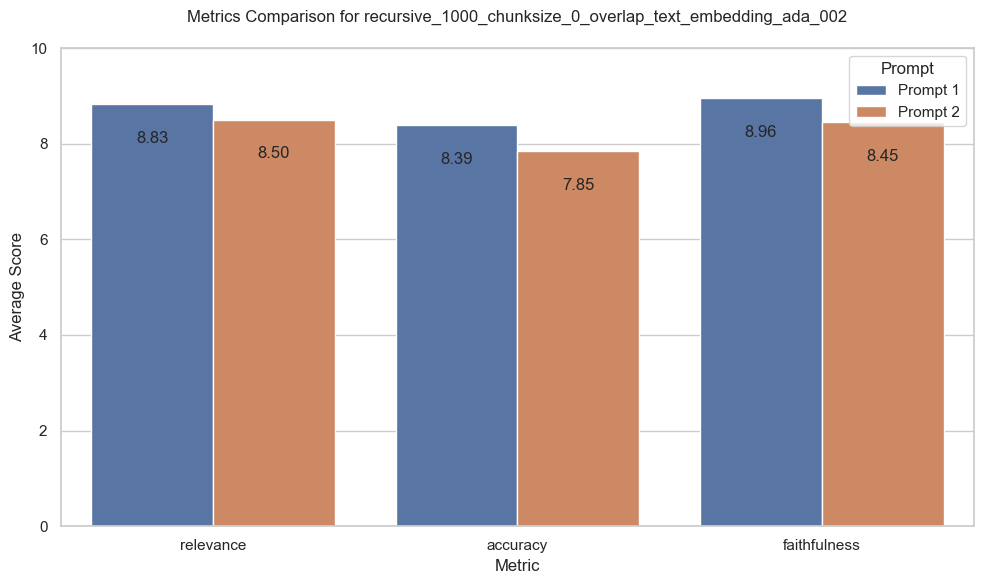

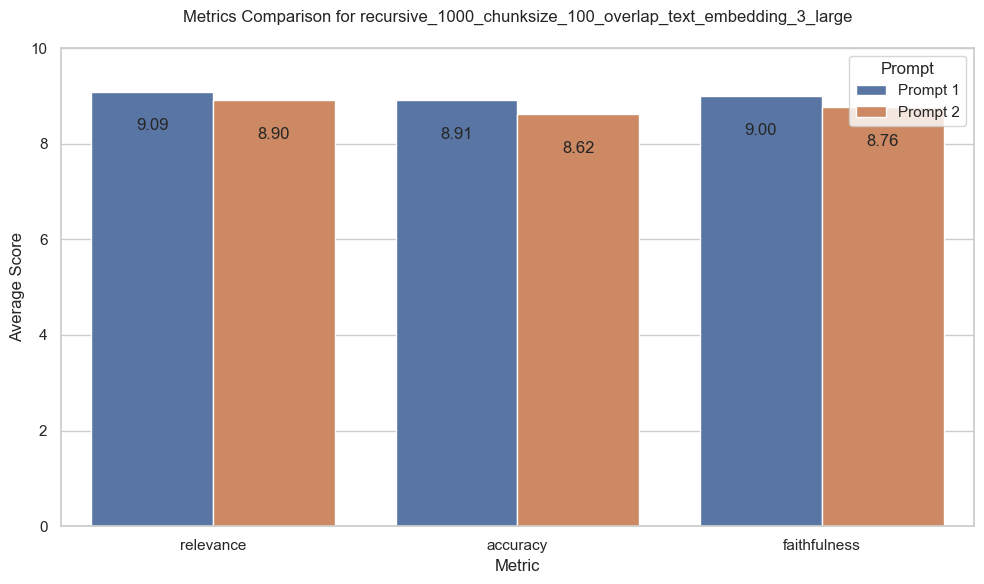

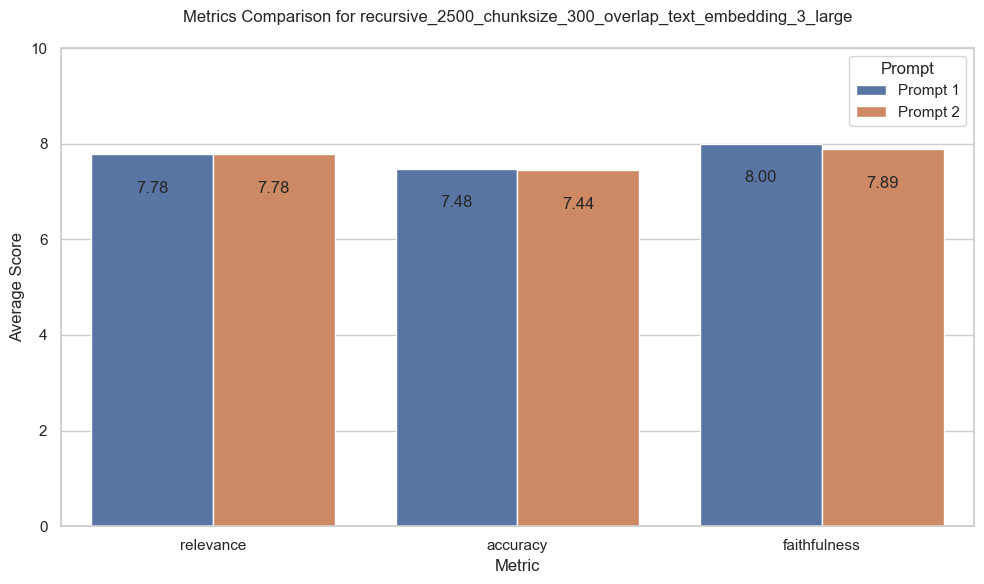

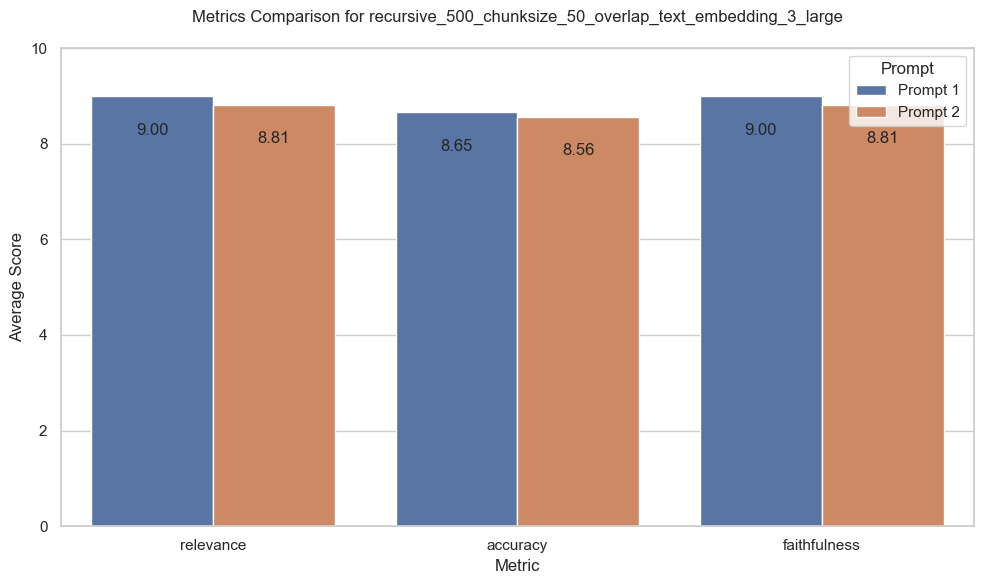

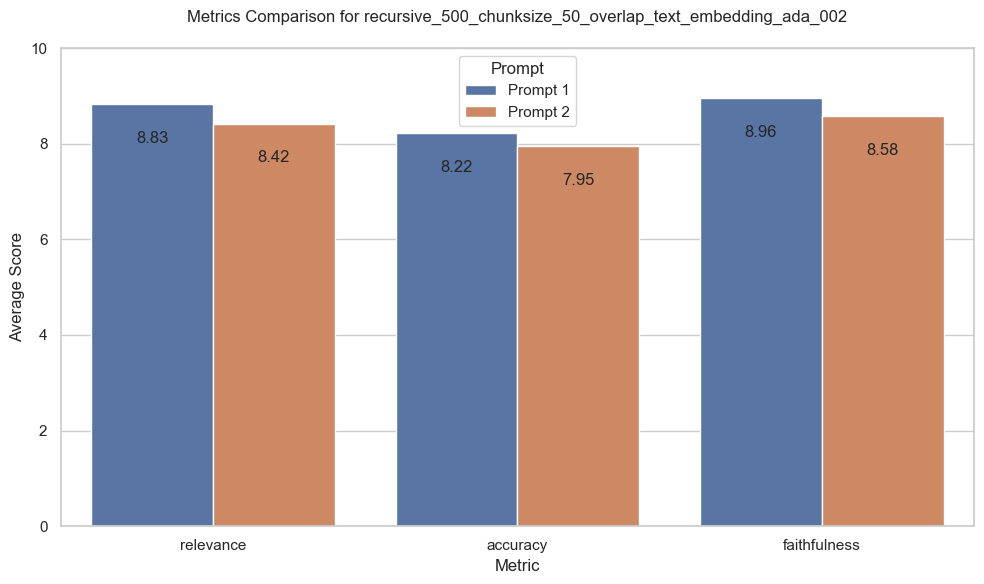

In [120]:
# Get the unique experiments
experiments = melted_data['file_name'].unique()

# Create a separate plot for each experiment
for experiment in experiments:
    experiment_data = melted_data[melted_data['file_name'] == experiment]
    
    plt.figure(figsize=(10, 6))
    barplot = sns.barplot(
        data=experiment_data,
        x='Metric',
        y='Score',
        hue='prompt_index'
    )
    
    # Add title and labels
    plt.title(f"Metrics Comparison for {experiment}\n")
    plt.xlabel('Metric')
    plt.ylabel('Average Score')
    plt.ylim(0, 10)

    # Add mean values on top of each bar
    for container in barplot.containers:
        barplot.bar_label(container, fmt='%.2f', padding=-30)
    
    # Automatically adjust the legend to match the plot
    handles, labels = barplot.get_legend_handles_labels()  # Get legend elements from the plot
    plt.legend(handles=handles, labels=['Prompt 1', 'Prompt 2'], title='Prompt')
    
    plt.tight_layout()
    plt.show()

It's clear to see that the prompt 1 delivers better results across all 3 metrics, especially when using the `text-embedding-ada-002`. Let's dive deeper and try to understand the worst results for each metric.

In [129]:
# remove all prompt 2
evaluation_df = evaluation_df[evaluation_df['prompt_index'] != 2]

In [130]:
# show 3 lowest scoring responses
lowest_relevance = evaluation_df.nsmallest(3, "relevance")

# show Question and Generated Answer
for i in range(3):
    print(f"Experiment: {lowest_relevance.iloc[i]['file_name']}")
    print(f"Question: {lowest_relevance.iloc[i]['user_input']}")
    print(f"Reference Answer: {lowest_relevance.iloc[i]['reference']}")
    print(f"Generated Answer: {lowest_relevance.iloc[i]['response']}")
    print("\n")

Experiment: evaluation_recursive_2500_chunksize_300_overlap_text_embedding_3_large.csv_Prompt_1.json
Question: What are the four focus areas of the EU's Green Deal Industrial Plan?
Reference Answer: The four focus areas of the EU's Green Deal Industrial Plan are the regulatory environment, access to finance, enhancing skills, and improving supply chain resilience.
Generated Answer: The four focus areas, or pillars, of the EU's Green Deal Industrial Plan are:

1.


Experiment: evaluation_recursive_2500_chunksize_300_overlap_text_embedding_3_large.csv_Prompt_1.json
Question: Does the Swedish government plan bans on new petrol and diesel cars?
Reference Answer: yes
Generated Answer: The context provided does not contain specific information about the Swedish government's plans to ban new petrol and diesel cars.


Experiment: evaluation_recursive_1000_chunksize_100_overlap_text_embedding_3_large.csv_Prompt_1.json
Question: In 2021, what were the top 3 states in the US in terms of total sol

Interesting to see that in the first example the model starts off the generated answer pretty well but then stopped mid sentence. This could have been caused by an api timeout or a bug in the model. 

The second and thrid examples explain that the there was no context provided to answer the specific question. Let us check the context for one of the examples:

In [131]:
print(lowest_relevance["retrieved_contexts"].iloc[0])

["The pillars identify the critical areas in which the EC believes it needs to act to match the plans that are being put forward by many of the major global industrial economies. Von der Leyen said that the key motivation behind the launch of the Green Deal Industrial Plan is the response of the US, Japan, the UK and Canada to the industrial and economic shift being created by the transition to net zero by 2050. The passage of the Inflation Reduction Act (IRA) in the US, the EUs largest trading partner, created a $ 369 billion opportunity to invest in technologies to enable the green transition. Yet, von der Leyen pointed out that elements of the IRA may not be beneficial to European trading partners, and could disrupt current transatlantic trade. While acknowledging that competition and trade could help accelerate the development of clean tech innovations, she pointed out the need for European industry to develop its own capabilities, supported by the four pillars proposed in the plan

We can see that the answer is not present in the context. The positive note is that the model did not hallucinate and generate a false answer and instead replied that the answer is not in the contexts. 

In [132]:
lowest_accuracy = evaluation_df.nsmallest(3, "accuracy")

# show Question and Generated Answer
for i in range(3):
    print(f"Experiment: {lowest_accuracy.iloc[i]['file_name']}")
    print(f"Question: {lowest_accuracy.iloc[i]['user_input']}")
    print(f"Reference Answer: {lowest_accuracy.iloc[i]['reference']}")
    print(f"Generated Answer: {lowest_accuracy.iloc[i]['response']}")
    print("\n")

Experiment: evaluation_recursive_2500_chunksize_300_overlap_text_embedding_3_large.csv_Prompt_1.json
Question: What are the four focus areas of the EU's Green Deal Industrial Plan?
Reference Answer: The four focus areas of the EU's Green Deal Industrial Plan are the regulatory environment, access to finance, enhancing skills, and improving supply chain resilience.
Generated Answer: The four focus areas, or pillars, of the EU's Green Deal Industrial Plan are:

1.


Experiment: evaluation_recursive_2500_chunksize_300_overlap_text_embedding_3_large.csv_Prompt_1.json
Question: Does the Swedish government plan bans on new petrol and diesel cars?
Reference Answer: yes
Generated Answer: The context provided does not contain specific information about the Swedish government's plans to ban new petrol and diesel cars.


Experiment: evaluation_recursive_1000_chunksize_0_overlap_text_embedding_ada_002.csv_Prompt_1.json
Question: Where do the turbines used in Icelandic geothermal power plants come 

In [133]:
lowest_faithfulness = evaluation_df.nsmallest(3, "faithfulness")

# show Question and Generated Answer
for i in range(3):
    print(f"Experiment: {lowest_faithfulness.iloc[i]['file_name']}")
    print(f"Question: {lowest_faithfulness.iloc[i]['user_input']}")
    print(f"Reference Answer: {lowest_faithfulness.iloc[i]['reference']}")
    print(f"Generated Answer: {lowest_faithfulness.iloc[i]['response']}")
    print("\n")

Experiment: evaluation_recursive_2500_chunksize_300_overlap_text_embedding_3_large.csv_Prompt_1.json
Question: What are the four focus areas of the EU's Green Deal Industrial Plan?
Reference Answer: The four focus areas of the EU's Green Deal Industrial Plan are the regulatory environment, access to finance, enhancing skills, and improving supply chain resilience.
Generated Answer: The four focus areas, or pillars, of the EU's Green Deal Industrial Plan are:

1.


Experiment: evaluation_recursive_2500_chunksize_300_overlap_text_embedding_3_large.csv_Prompt_1.json
Question: What are the basic recycling steps for solar panels?
Reference Answer: removing the frames, glass covers, and solar connectors
Generated Answer: The basic recycling steps for solar panels, as suggested by the context, include:

1.


Experiment: evaluation_recursive_2500_chunksize_300_overlap_text_embedding_3_large.csv_Prompt_1.json
Question: Why does melting ice contribute to global warming?
Reference Answer: Melting

The worst scoring faithfulness examples are also interesting. The first two shown above have the same issue as the other metrics, where the model stopped generating an answer mid-sentence.

The generated answer in the third example is not precise or detailed enough, therefore a low faithfulness score is accurately given.

### Evaluation with Metrics

Here we will create plots to visualize the calculated metrics; rouge, bleu and cosine similarity.

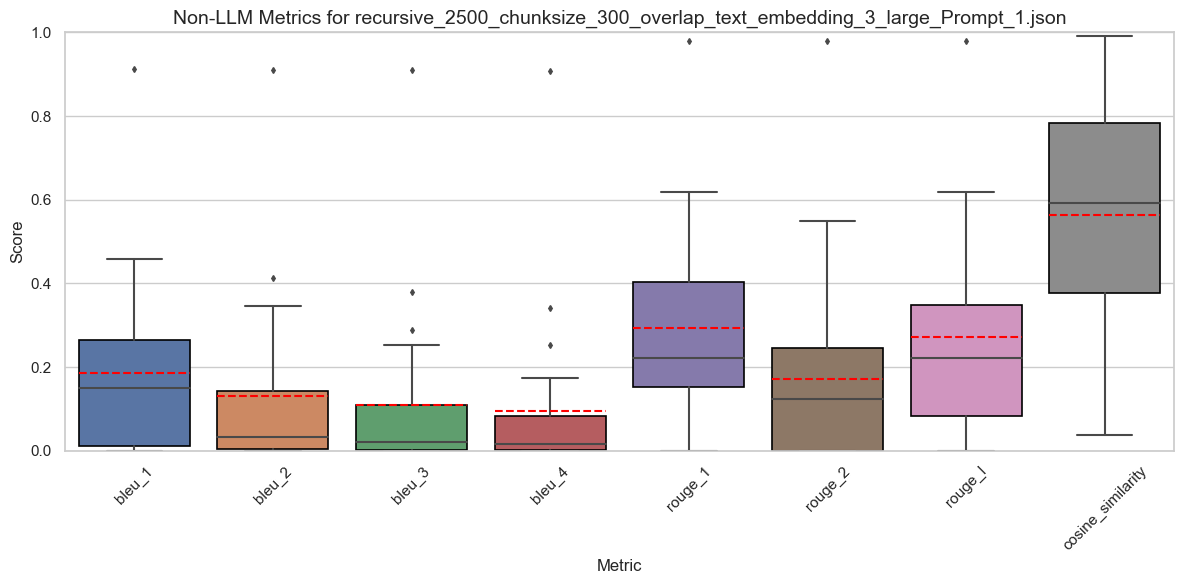

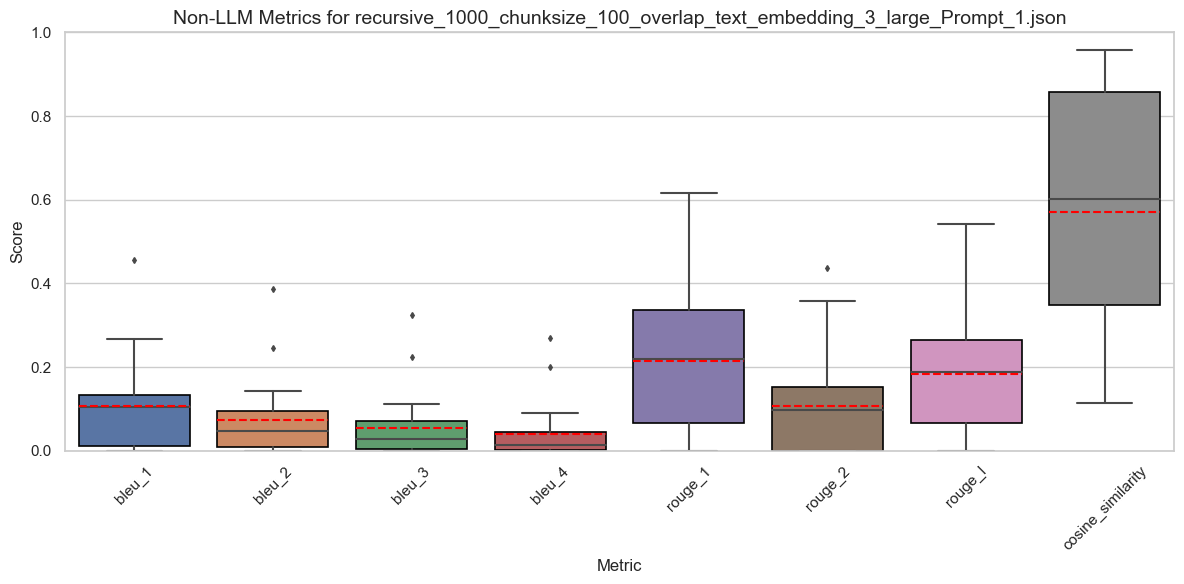

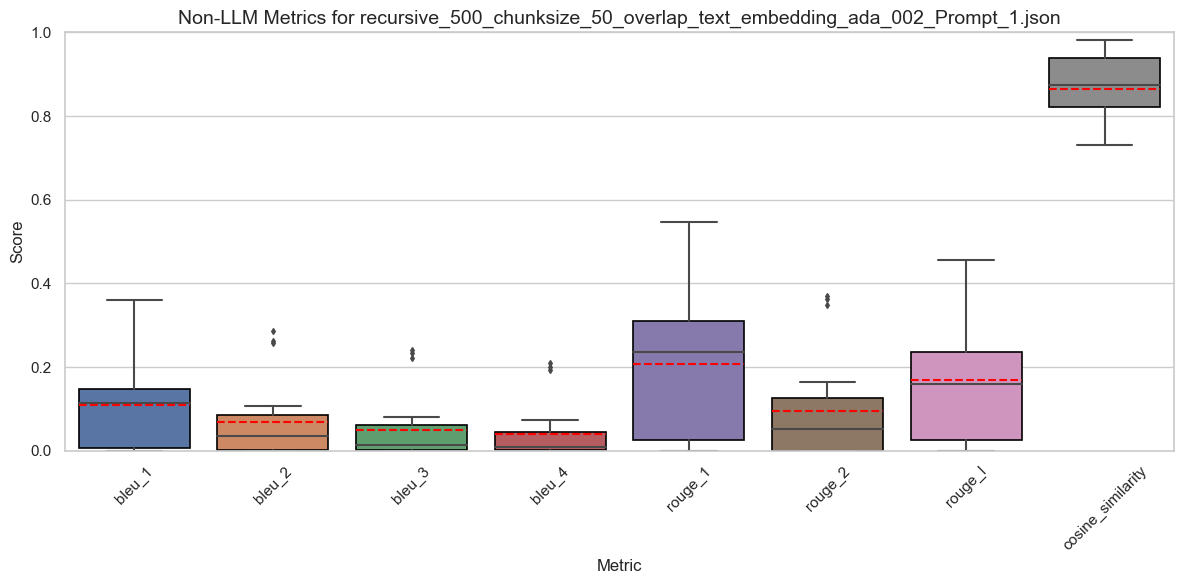

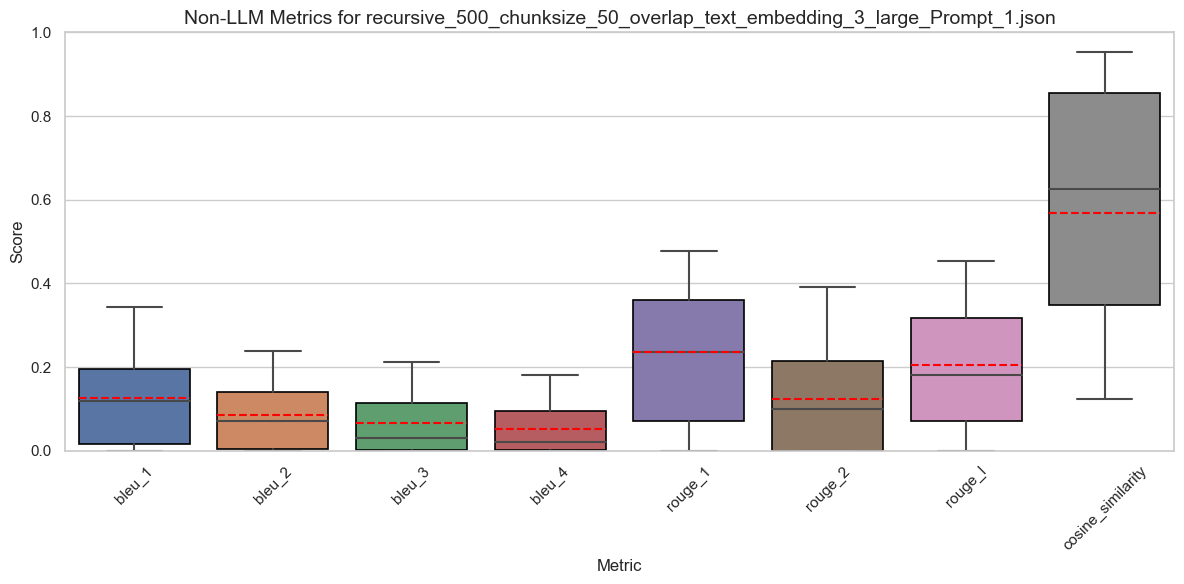

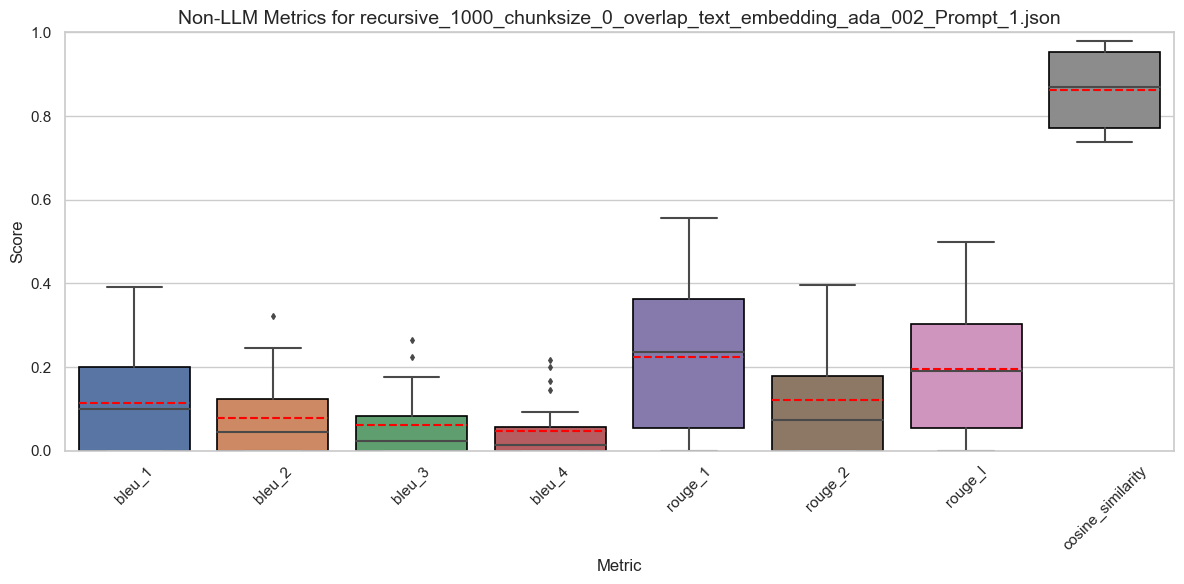

In [134]:
non_llm_metrics = [
    'bleu_1', 'bleu_2', 'bleu_3', 'bleu_4',
    'rouge_1', 'rouge_2', 'rouge_l', 'cosine_similarity'
]

# Melt the DataFrame for easier plotting
melted_non_llm = evaluation_df.melt(
    id_vars=['file_name'],  # Keep file_name for grouping
    value_vars=non_llm_metrics,  # Metrics to plot
    var_name='Metric',  # Name of the metric column
    value_name='Score'  # Name of the value column
)

# Remove "evaluation" and ".csv" from file_name for cleaner plots
melted_non_llm['file_name'] = melted_non_llm['file_name'].str.replace("evaluation_", "").str.replace(".csv", "", regex=False)

# Get unique experiments
experiments = melted_non_llm['file_name'].unique()

# Plot for each experiment
for experiment in experiments:
    experiment_data = melted_non_llm[melted_non_llm['file_name'] == experiment]
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(
        data=experiment_data,
        x='Metric',
        y='Score',
        showmeans=True,
        meanline=True,
        meanprops={"color": "red", "linestyle": "--", "linewidth": 1.5},
        boxprops={"edgecolor": "black", "linewidth": 1.2},
        fliersize=3  # Control size of outliers
    )
    
    # Add title and labels
    plt.title(f"Non-LLM Metrics for {experiment}", fontsize=14)
    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.ylim(0, 1)  # Assuming BLEU, ROUGE, and cosine similarity are between 0 and 1
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

Interesting to see that the experiments with `text-embedding-ada-002` have higher cosine similarity scores compared to `text-embedding-3-large` and also that the distribution is less variable. 

It also seems that the experiment with `recursive_2500_chunksize_300_overlap_text_embedding_3_large` delivers the highest BLEU and ROUGE scores.

Other than that there is no significant difference between the results two embedding models.

### Random Sample Evaluation

Random sampling is included as a critical step to manually evaluate model outputs. While automated metrics (for example BLEU, ROUGE, cosine similarity) and LLM-based evaluations provide quantitative measures of quality, manual evaluation ensures a qualitative understanding of the model's performance.

**Benefits**
- Diverse Evaluation: Ensures a mix of easy and challenging questions is included in the evaluation.
- Improved Model Understanding: Highlights areas where the model performs well and identifies edge cases.
- Human Judgment: Provides insights that automated metrics cannot capture, such as tone, clarity, and user satisfaction.

In [142]:
import random

# Number of random samples to pick
num_samples = 3 

# Randomly select rows from the evaluation DataFrame
random_samples = evaluation_df.sample(n=num_samples, random_state=42)

# Display the random samples with all key columns for manual review
print("=== Random Evaluation Samples ===\n")
for index, row in random_samples.iterrows():
    print(f"Experiment: {row['file_name']}")
    print(f"Question: {row['user_input']}")
    print(f"Reference Answer: {row['reference']}")
    print(f"Generated Answer: {row['response']}")
    print(f"Retrieved Contexts: {row['retrieved_contexts']}")
    print(f"Relevance Score: {row['relevance']}")
    print(f"Accuracy Score: {row['accuracy']}")
    print(f"Faithfulness Score: {row['faithfulness']}")
    print("-" * 100)

=== Random Evaluation Samples ===

Experiment: evaluation_recursive_500_chunksize_50_overlap_text_embedding_3_large.csv_Prompt_1.json
Question: What are the basic recycling steps for solar panels?
Reference Answer: removing the frames, glass covers, and solar connectors
Generated Answer: The basic recycling steps for solar panels include removing the panels' frames, glass covers, and solar connectors before they are disposed of. This process helps to reduce the waste volume.
Retrieved Contexts: ['making recycling checklists and finding preferred partners in 2019, and a grassroots website ( SolarRecycle.org) has collected information on reuse, resale and recycle outlets that accept solar materials. But the biggest step forward for the solar recycling space came with the 2022 founding of SolarCycle, a PV-technology-based recycler that opened a processing facility in Odessa, Texas, that recovers 95% of a solar panel’ s value. Both national residential installer Sunrun and utility-scale', 

Looking at the randomly picked examples, we can see that the model is able to generate relevant and accurate answers from the retrieved data for most of the questions. Therefore our plausability check is passed.